In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import random
import pickle
import osmnx as ox
import copy
import json

In [7]:
"""
Input
"""
SEED = 1
example = 12
num_nodes = 50
num_client = 5


In [8]:
"""
Set seed
"""
random.seed(SEED)

In [9]:
"""
Build a graph
"""

# Read the network data 
G = pickle.load(open("Manhattan_network.p", "rb"))


# Generate the set of nodes of a subgraph by BFS
def graph_generator(G, num_nodes):
    V = list(G.nodes)
    E = list(G.edges)
    s = random.sample(V, 1)[0]

    visited = [s]
    frontier = [s]
    while len(visited) < num_nodes and len(frontier) > 0:
        i = frontier.pop(0)
        for j in G.neighbors(i):
            if j not in visited:
                visited.append(j)
                frontier.append(j)
    
    return visited

tmp_V = graph_generator(G, num_nodes)
G = G.subgraph(tmp_V)


# Extract the strongly connected components
tmp_V = max(nx.strongly_connected_components(G), key = len)
G = G.subgraph(list(tmp_V))
V = list(G.nodes)
E = list(G.edges)

# label mapping
old_to_new = {}
new_to_old = {}
index = 0
for i in V:
    new_to_old[index] = i
    old_to_new[i] = index
    index += 1

In [10]:
"""
Set parameters
"""

## Depots
K = random.sample(V, 1)

## Trucks
num_auto = 2
num_non_auto = 2
num_truck = num_auto + num_non_auto ### The first half are auto trucks
truck = np.arange(num_truck)

truck_range = (np.random.random(len(truck))) * 50 * 1600
truck_capacity = 5

# Fixed cost to dispatch a truck
truck_cost = np.repeat(20, len(truck))


## Clients
D = random.sample(list(set(V) - set(K)), num_client)

demand = np.random.lognormal(0.1, 1, size=len(D))
demand[demand >= truck_capacity] = truck_capacity

## Budget
budget = 1

## Time discretization

# The length of time intervals (in minutes)
gran = 5
# The # of operational hours (in hours)
op = 12
# Time span (in seconds)
T = op * 3600

num_interval = int((60 / gran) * op)
Q = np.arange(num_interval)
a = np.arange(0, T, gran * 60)
b = a + gran * 60



/home/zh223/miniconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/zh223/miniconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


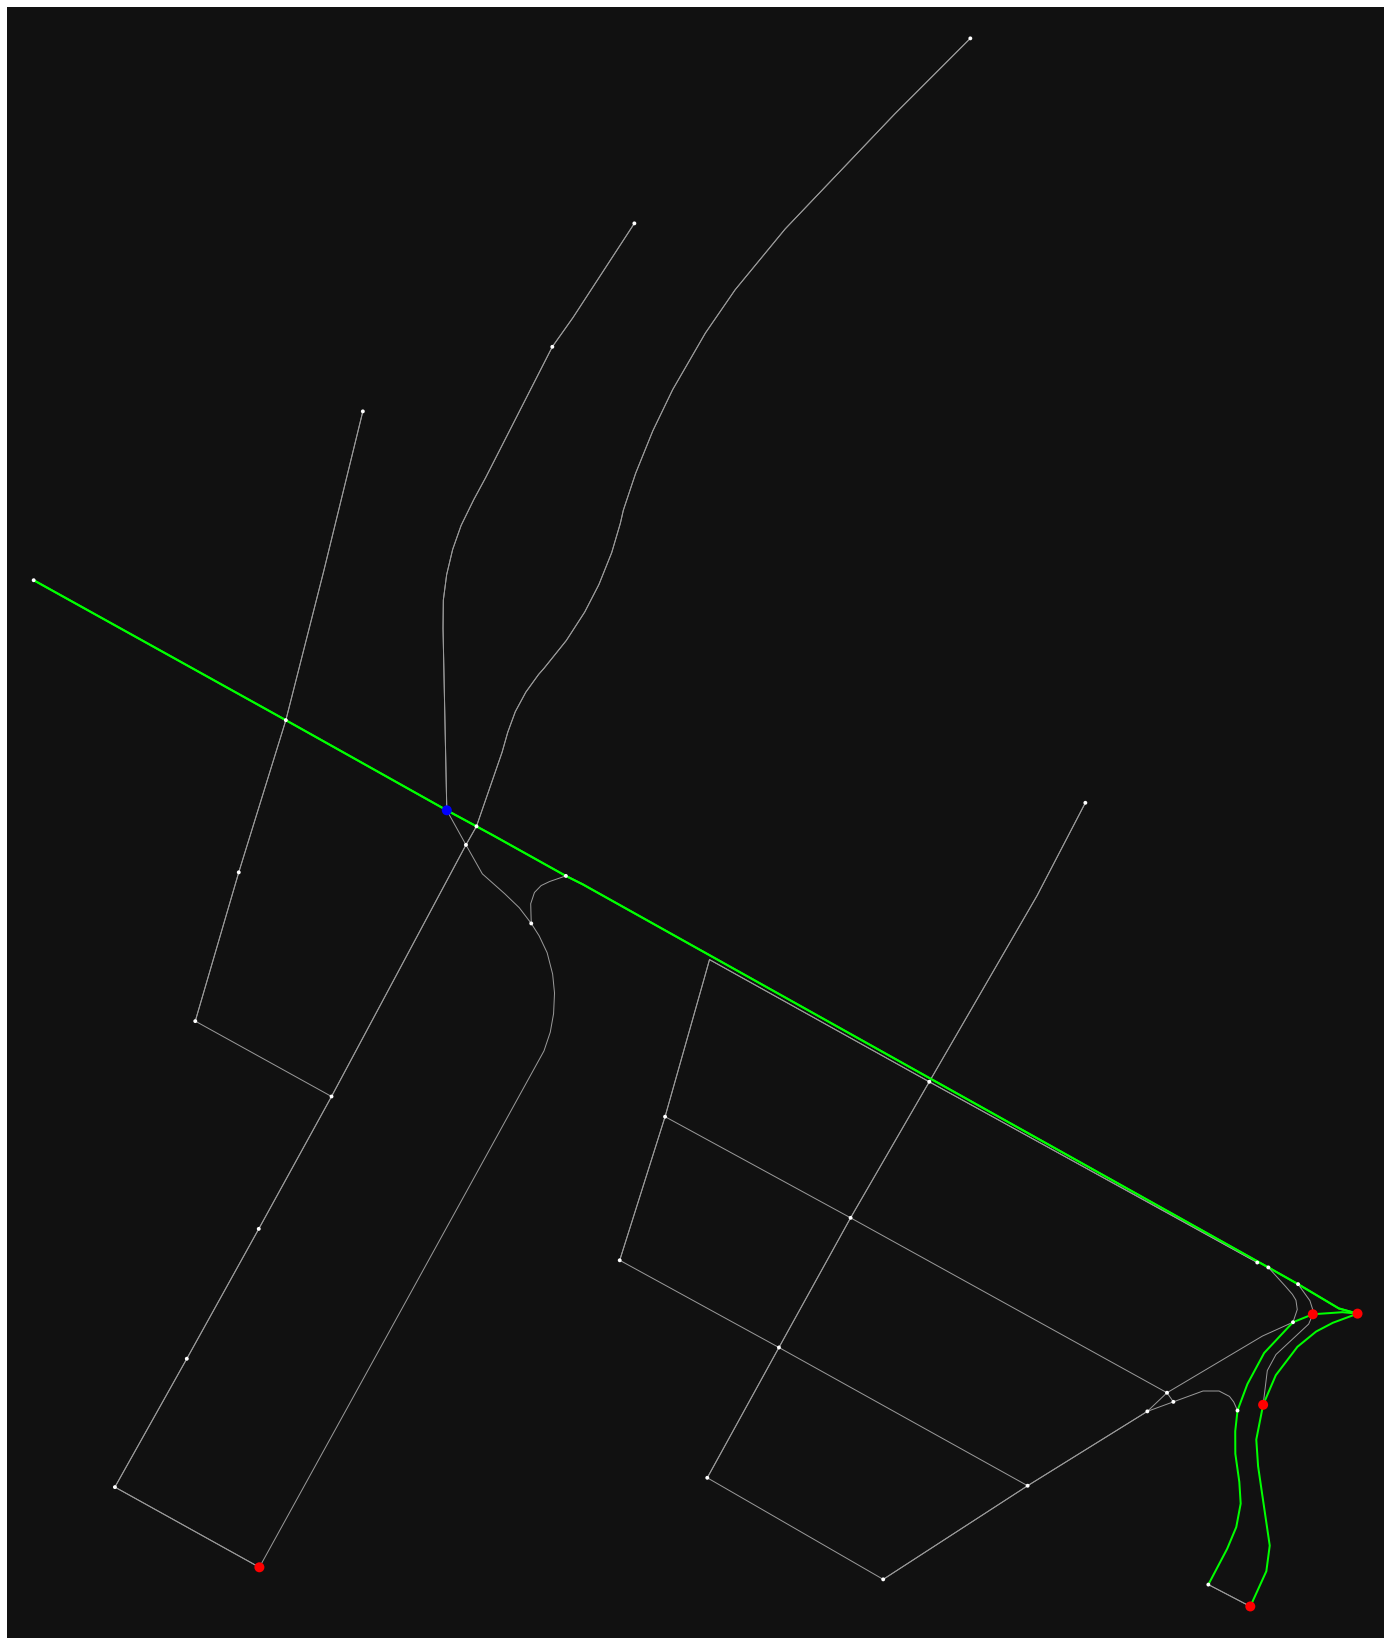

(<Figure size 2160x2160 with 1 Axes>, <AxesSubplot:>)

In [11]:
"""
Visualization
"""

# index_K = [i for i in range(len(V)) if V[i] in K]
# index_D = [i for i in range(len(V)) if V[i] in D]
index_auto_E = [i for i in range(len(E)) if G.edges[E[i]]['highway'] == 'primary']
node_color = ['w' for _ in range(len(V))]
node_size = [15 for _ in range(len(V))]
edge_color = ['#999999' for _ in range(len(E))]
edge_linewidth = [1 for _ in range(len(E))]

for i in K:
    idx = old_to_new[i]
    node_color[idx] = 'b'
    node_size[idx] = 100
for i in D:
    idx = old_to_new[i]
    node_color[idx] = 'r'
    node_size[idx] = 100
for idx in index_auto_E:
    edge_color[idx] = '#00FF00'
    edge_linewidth[idx] = 2

ox.plot_graph(G, node_color = node_color, node_size = node_size, edge_color = edge_color, 
                edge_linewidth = edge_linewidth, figsize = (30, 30), save = True, filepath = 'example-' + str(example) + '/network.png')

In [12]:
"""
Build the extended graph
"""

G_e = copy.deepcopy(G)
D_e = [old_to_new[i] for i in D]
for i in range(len(D) - 1):

    # Duplicate one more layer
    layer = copy.deepcopy(G) 
    G_e = nx.disjoint_union(G_e, layer)

    # Add artificial edges of customers 
    for j in D:
        idx_j = old_to_new[j]
        idx_1 = idx_j + i * len(V)
        idx_2 = idx_j + (i+1) * len(V)
        D_e.append(idx_2)
        G_e.add_edge(idx_1, idx_2, length = 0, highway = 'artificial', index = str(idx_1)+'-'+str(idx_2))

# Construct the demand dictionary
demand_dict = dict(zip(D_e, np.tile(demand, num_client)))

# Construct the 2-D customer vertices
D_e_2d = np.reshape(D_e, (len(D), len(D)))

# Add artificial edges of the depot
departure = old_to_new[K[0]]
K_e = []
for i in range(len(D) - 1):
    idx_1 = departure + i * len(V)
    idx_2 = departure + (len(D) - 1) * len(V)
    K_e.append(idx_1)
    G_e.add_edge(idx_1, idx_2, length = 0, highway = 'artificial', index = str(idx_1)+'-'+str(idx_2))
arrival = departure + (len(D) - 1) * len(V)
K_e.append(arrival)

# Make new lists of nodes and edges in the extended graph
E_e = list(G_e.edges())
V_e = list(G_e.nodes)


# Mapping for edges
edge_to_no = {}
no_to_edge = {}
index = 0
for e in E_e:
    no_to_edge[index] = e
    edge_to_no[e] = index
    index += 1

# Sanity Check 
counter = 0
for j in range(len(D) - 1):

    tmp_k = old_to_new[K[0]]
    print(G_e[tmp_k + j * len(V)][tmp_k + (len(D)-1) * len(V)])
    print('++++++++++++++++++++++')
    for i in D:
        tmp_i = old_to_new[i]
        print(G_e[tmp_i + j * len(V)][tmp_i + (j+1) * len(V)])
        counter += 1
    print('======================')

print("The size of the extended graph is: ")
print(len(E_e))
print(len(V_e))


{0: {'length': 0, 'highway': 'artificial', 'index': '36-196'}}
++++++++++++++++++++++
{0: {'length': 0, 'highway': 'artificial', 'index': '4-44'}}
{0: {'length': 0, 'highway': 'artificial', 'index': '16-56'}}
{0: {'length': 0, 'highway': 'artificial', 'index': '7-47'}}
{0: {'length': 0, 'highway': 'artificial', 'index': '31-71'}}
{0: {'length': 0, 'highway': 'artificial', 'index': '28-68'}}
{0: {'length': 0, 'highway': 'artificial', 'index': '76-196'}}
++++++++++++++++++++++
{0: {'length': 0, 'highway': 'artificial', 'index': '44-84'}}
{0: {'length': 0, 'highway': 'artificial', 'index': '56-96'}}
{0: {'length': 0, 'highway': 'artificial', 'index': '47-87'}}
{0: {'length': 0, 'highway': 'artificial', 'index': '71-111'}}
{0: {'length': 0, 'highway': 'artificial', 'index': '68-108'}}
{0: {'length': 0, 'highway': 'artificial', 'index': '116-196'}}
++++++++++++++++++++++
{0: {'length': 0, 'highway': 'artificial', 'index': '84-124'}}
{0: {'length': 0, 'highway': 'artificial', 'index': '96-13

In [13]:
"""
Cost and travel time
"""

speed = 3.3528 # in meter/second
for e in E_e:
    e = (e[0], e[1], 0)
    G_e.edges[e]['travel_time'] = G_e.edges[e]['length'] / speed

for e in E_e:
    e = (e[0], e[1], 0)
    if G_e.edges[e]['highway'] == 'artificial':
        G_e.edges[e]['auto_cost'] = 0
        G_e.edges[e]['non_auto_cost'] = 0
    elif G_e.edges[e]['highway'] == 'primary':
        G_e.edges[e]['auto_cost'] = 0.5 * G_e.edges[e]['length']
        G_e.edges[e]['non_auto_cost'] = G_e.edges[e]['length']
    else:
        G_e.edges[e]['auto_cost'] = 1.2 * G_e.edges[e]['length']
        G_e.edges[e]['non_auto_cost'] = G_e.edges[e]['length']

In [42]:
# """
# The MILP solver (Dense Representation)
# """

# # Create a new model
# model = gp.Model('auto_truck')

# # Set the file path for logging
# model.Params.LogFile = 'example-' + str(example) + '/log.txt'


# # Create variables
# x = model.addMVar((len(V_e), len(V_e), num_truck), vtype=GRB.BINARY)
# y = model.addMVar((len(V_e), num_truck), vtype=GRB.BINARY)
# t = model.addMVar((len(V_e), num_truck), vtype=GRB.CONTINUOUS)
# u = model.addMVar((num_interval, num_auto), vtype=GRB.BINARY)
# alpha = model.addMVar((num_interval, len(V_e), len(V_e), num_auto), vtype=GRB.BINARY)
# beta = model.addMVar((num_interval, len(V_e), len(V_e), num_auto), vtype=GRB.BINARY)


# # Add constraints

# ## Flow conservation at all nodes (except the depot)
# model.addConstrs(sum(x[i, list(G_e.successors(i)), m]) == sum(x[list(G_e.predecessors(i)), i, m])
#                 for i in list(set(V_e) - set([departure, arrival]))
#                 for m in truck)

# ## Flow conservation at the depot
# model.addConstrs(sum(x[departure, list(G_e.successors(departure)), m]) == y[departure, m]
#                 for m in truck)
# model.addConstrs(sum(x[list(G_e.predecessors(arrival)), arrival, m]) == y[arrival, m]
#                 for m in truck)
# model.addConstrs(y[departure, m] == y[arrival, m]
#                 for m in truck)

# ## The # of truck used
# model.addConstr(sum(y[departure, :]) <= len(truck))

# ## Each truck serves only one customer
# model.addConstrs(sum(x[list(G_e.predecessors(i)), i, m]) >= y[i, m] for i in D_e for m in truck)
# model.addConstrs(sum(y[i, m] for i in D_e_2d[:, h] for m in truck) == 1 for h in range(len(D)))
    

# ## Transition
# for i in D_e + K_e[1 :]:
#     for j in D_e + K_e[1 :]:
#         if G_e.has_edge(i, j) and G_e[i][j][0]['highway'] == 'artificial':
#             model.addConstrs(x[i, j, m] == y[i, m] for m in truck)


# ## Range limit
# model.addConstrs(sum(G_e[i][j][0]['length'] * x[i, j, m] for i in V_e for j in V_e if G_e.has_edge(i, j)) <= truck_range[m]
#                 for m in truck)

# ## Capacity limit
# model.addConstrs(sum(demand_dict[i] * y[i, m] for i in D_e) <= 2 * truck_capacity
#                 for m in truck)

# ## Subtour elimination + time tracking
# for i in V_e:
#     for j in V_e:
#         if G_e.has_edge(i, j):
#             model.addConstrs(t[j, m] >= t[i, m] + G_e[i][j][0]['travel_time'] + T * (x[i, j, m] - 1) for m in truck)
# model.addConstrs(t[arrival, m] == t[departure, m] + sum(G_e[i][j][0]['travel_time'] * x[i, j, m] for i in V_e for j in V_e if G_e.has_edge(i, j))
#                 for m in truck)

# ## Budget of remote control
# model.addConstrs(sum(u[q, :]) <= budget for q in Q)

# ## Time consistency of a truck being remotely controlled
# for i in V_e:
#     for j in V_e:
#         if G_e.has_edge(i, j) and G_e[i][j][0]['highway'] == 'primary':
#             model.addConstrs(3 * u[q, m] >= alpha[q, i, j, m] + beta[q, i, j, m] + x[i, j, m] - 2
#                             for q in Q
#                             for m in truck[: num_auto])
#             model.addConstrs(t[j, m] - T * (alpha[q, i, j, m]) <= a[q]
#                             for q in Q
#                             for m in truck[: num_auto])
#             model.addConstrs(t[i, m] >= b[q] - T * (beta[q, i, j, m])
#                             for q in Q
#                             for m in truck[: num_auto])


# # Add the objective
# model.setObjective(sum(x[i, j, m] * G_e[i][j][0]['auto_cost'] for i in V_e for j in V_e for m in truck[: num_auto] if G_e.has_edge(i, j)) + 
#                    sum(x[i, j, m] * G_e[i][j][0]['non_auto_cost'] for i in V_e for j in V_e for m in truck[num_auto :] if G_e.has_edge(i, j)),
#                    GRB.MINIMIZE)

# # Wirte the model itself
# # model.write('example-' + str(example) +'/model.lp')

# # Solve the VRP
# model.optimize()

# # Write the solution
# # model.write('example-' + str(example) + '/solution.sol')

In [14]:
"""
The MILP Sovler (Sparse Representation)
"""

# Create a new model
model = gp.Model('auto_truck')

# Set the file path for logging
model.Params.LogFile = 'example-' + str(example) + '/log.txt'


# Create variables
x = model.addMVar((len(E_e), num_truck), vtype=GRB.BINARY)
y = model.addMVar((len(V_e), num_truck), vtype=GRB.BINARY)
t = model.addMVar((len(V_e), num_truck), vtype=GRB.CONTINUOUS)
u = model.addMVar((num_interval, num_auto), vtype=GRB.BINARY)
alpha = model.addMVar((num_interval, len(E_e), num_auto), vtype=GRB.BINARY)
beta = model.addMVar((num_interval, len(E_e), num_auto), vtype=GRB.BINARY)


# Add constraints

## Flow conservation at all nodes (except the depot)
for i in list(set(V_e) - set([departure, arrival])):
    out_no = [edge_to_no[e] for e in list(G_e.out_edges(i))]
    in_no = [edge_to_no[e] for e in list(G_e.in_edges(i))]
    model.addConstrs(sum(x[out_no, m]) == sum(x[in_no, m]) for m in truck)

## Flow conservation at the depot
departure_out = [edge_to_no[e] for e in list(G_e.out_edges(departure))]
arrival_in = [edge_to_no[e] for e in list(G_e.in_edges(arrival))]

model.addConstrs(sum(x[departure_out, m]) == y[departure, m]
                for m in truck)
model.addConstrs(sum(x[arrival_in, m]) == y[arrival, m]
                for m in truck)
model.addConstrs(y[departure, m] == y[arrival, m]
                for m in truck)

## The # of truck used
model.addConstr(sum(y[departure, :]) <= len(truck))

## Each truck serves only one customer
for i in D_e:
    i_in = [edge_to_no[e] for e in list(G_e.in_edges(i))]
    model.addConstrs(sum(x[i_in, m]) >= y[i, m] for m in truck)
model.addConstrs(sum(y[i, m] for i in D_e_2d[:, h] for m in truck) == 1 for h in range(len(D)))


## Transition
for i in D_e + K_e[1 :]:
    for j in D_e + K_e[1 :]:
        if G_e.has_edge(i, j) and G_e[i][j][0]['highway'] == 'artificial':
            model.addConstrs(x[edge_to_no[(i, j)], m] == y[i, m] for m in truck)

## Range limit
model.addConstrs(sum(G_e[i][j][0]['length'] * x[edge_to_no[(i, j)], m] for i in V_e for j in V_e if G_e.has_edge(i, j)) <= truck_range[m]
                for m in truck)

## Capacity limit
model.addConstrs(sum(demand_dict[i] * y[i, m] for i in D_e) <= 2 * truck_capacity
                for m in truck)
            
## Subtour elimination + time tracking
for i in V_e:
    for j in V_e:
        if G_e.has_edge(i, j):
            model.addConstrs(t[j, m] >= t[i, m] + G_e[i][j][0]['travel_time'] + T * (x[edge_to_no[(i, j)], m] - 1) for m in truck)
model.addConstrs(t[arrival, m] == t[departure, m] + sum(G_e[i][j][0]['travel_time'] * x[edge_to_no[(i, j)], m] for i in V_e for j in V_e if G_e.has_edge(i, j))
                for m in truck)

## Budget of remote control
model.addConstrs(sum(u[q, :]) <= budget for q in Q)

## Time consistency of a truck being remotely controlled
for i in V_e:
    for j in V_e:
        if G_e.has_edge(i, j) and G_e[i][j][0]['highway'] == 'primary':
            model.addConstrs(3 * u[q, m] >= alpha[q, edge_to_no[(i, j)], m] + beta[q, edge_to_no[(i, j)], m] + x[edge_to_no[(i, j)], m] - 2
                            for q in Q
                            for m in truck[: num_auto])
            model.addConstrs(t[j, m] - T * (alpha[q, edge_to_no[(i, j)], m]) <= a[q]
                            for q in Q
                            for m in truck[: num_auto])
            model.addConstrs(t[i, m] >= b[q] - T * (beta[q, edge_to_no[(i, j)], m])
                            for q in Q
                            for m in truck[: num_auto])

# Add the objective
model.setObjective(sum(x[edge_to_no[(i, j)], m] * G_e[i][j][0]['auto_cost'] for i in V_e for j in V_e for m in truck[: num_auto] if G_e.has_edge(i, j)) + 
                   sum(x[edge_to_no[(i, j)], m] * G_e[i][j][0]['non_auto_cost'] for i in V_e for j in V_e for m in truck[num_auto :] if G_e.has_edge(i, j)) +
                   y[departure, :] @ truck_cost,
                   GRB.MINIMIZE)

# Solve the VRP
model.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2023-04-23
Set parameter LogFile to value "example-12/log.txt"
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 16 physical cores, 32 logical processors, using up to 32 threads
Optimize a model with 89294 rows, 253608 columns and 243372 nonzeros
Model fingerprint: 0x0852035c
Variable types: 800 continuous, 252808 integer (252808 binary)
Coefficient statistics:
  Matrix range     [6e-01, 4e+04]
  Objective range  [6e+00, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+04]
Presolve removed 781 rows and 193804 columns
Presolve time: 0.95s
Presolved: 88513 rows, 59804 columns, 238604 nonzeros
Variable types: 691 continuous, 59113 integer (59113 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.21s

Solved with primal simplex

Root relaxation: objective 4.149142e+02, 847 iterations, 0.70 seconds 

In [44]:
# """
# Extract the routes (Dense Representation)
# """

# route = []
# tmp_route = [departure]

# for m in truck:
    
#     departure_succ = list(G_e.successors(departure))
#     departure_outflow = x[departure, departure_succ, m].X
#     if sum(departure_outflow) == 0:
#         route.append([])
#         continue
    
#     route_m = [new_to_old[departure]]
#     i = departure
#     while i != arrival:
#         succ = list(G_e.successors(i))
#         outflow = x[i, succ, m].X
#         next = int(succ @ outflow)
#         if next % len(V) != i % len(V):
#             route_m.append(new_to_old[next % len(V)])
#         i = next
#         if m == 1:
#             tmp_route.append(i)
#     route.append(route_m)



In [15]:
"""
Extract the routes (Sparse Representation)
"""

route = []
# tmp_route = [departure]

for m in truck:
    
    departure_out_edge_no = [edge_to_no[e] for e in list(G_e.out_edges(departure))]
    departure_outflow = x[departure_out_edge_no, m].X
    
    if sum(departure_outflow) == 0:
        route.append([])
        continue
    
    route_m = [new_to_old[departure]]
    i = departure
    while i != arrival:

        i_out_edges = list(G_e.out_edges(i))
        i_out_edges_no = [edge_to_no[e] for e in i_out_edges]
        i_outflow = x[i_out_edges_no, m].X
        next_edge = i_out_edges[np.where(i_outflow)[0][0]]
        next_node = next_edge[1]
        
        if next_node % len(V) != i % len(V):
            route_m.append(new_to_old[next_node % len(V)])
        i = next_node
        # if m == 1:
            # tmp_route.append(i)
    route.append(route_m)

In [16]:
"""
Write the routes to a json file
"""

dict_routes = dict(zip(range(len(route)), route))
with open('example-' +str(example) + '/routes.json', 'w') as outfile:
    json.dump(dict_routes, outfile)

['#f1ca20', '#c25ced', '#6b7f32', '#300e5d', '#f9c859']
example-12/route-1.png


/home/zh223/miniconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/zh223/miniconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


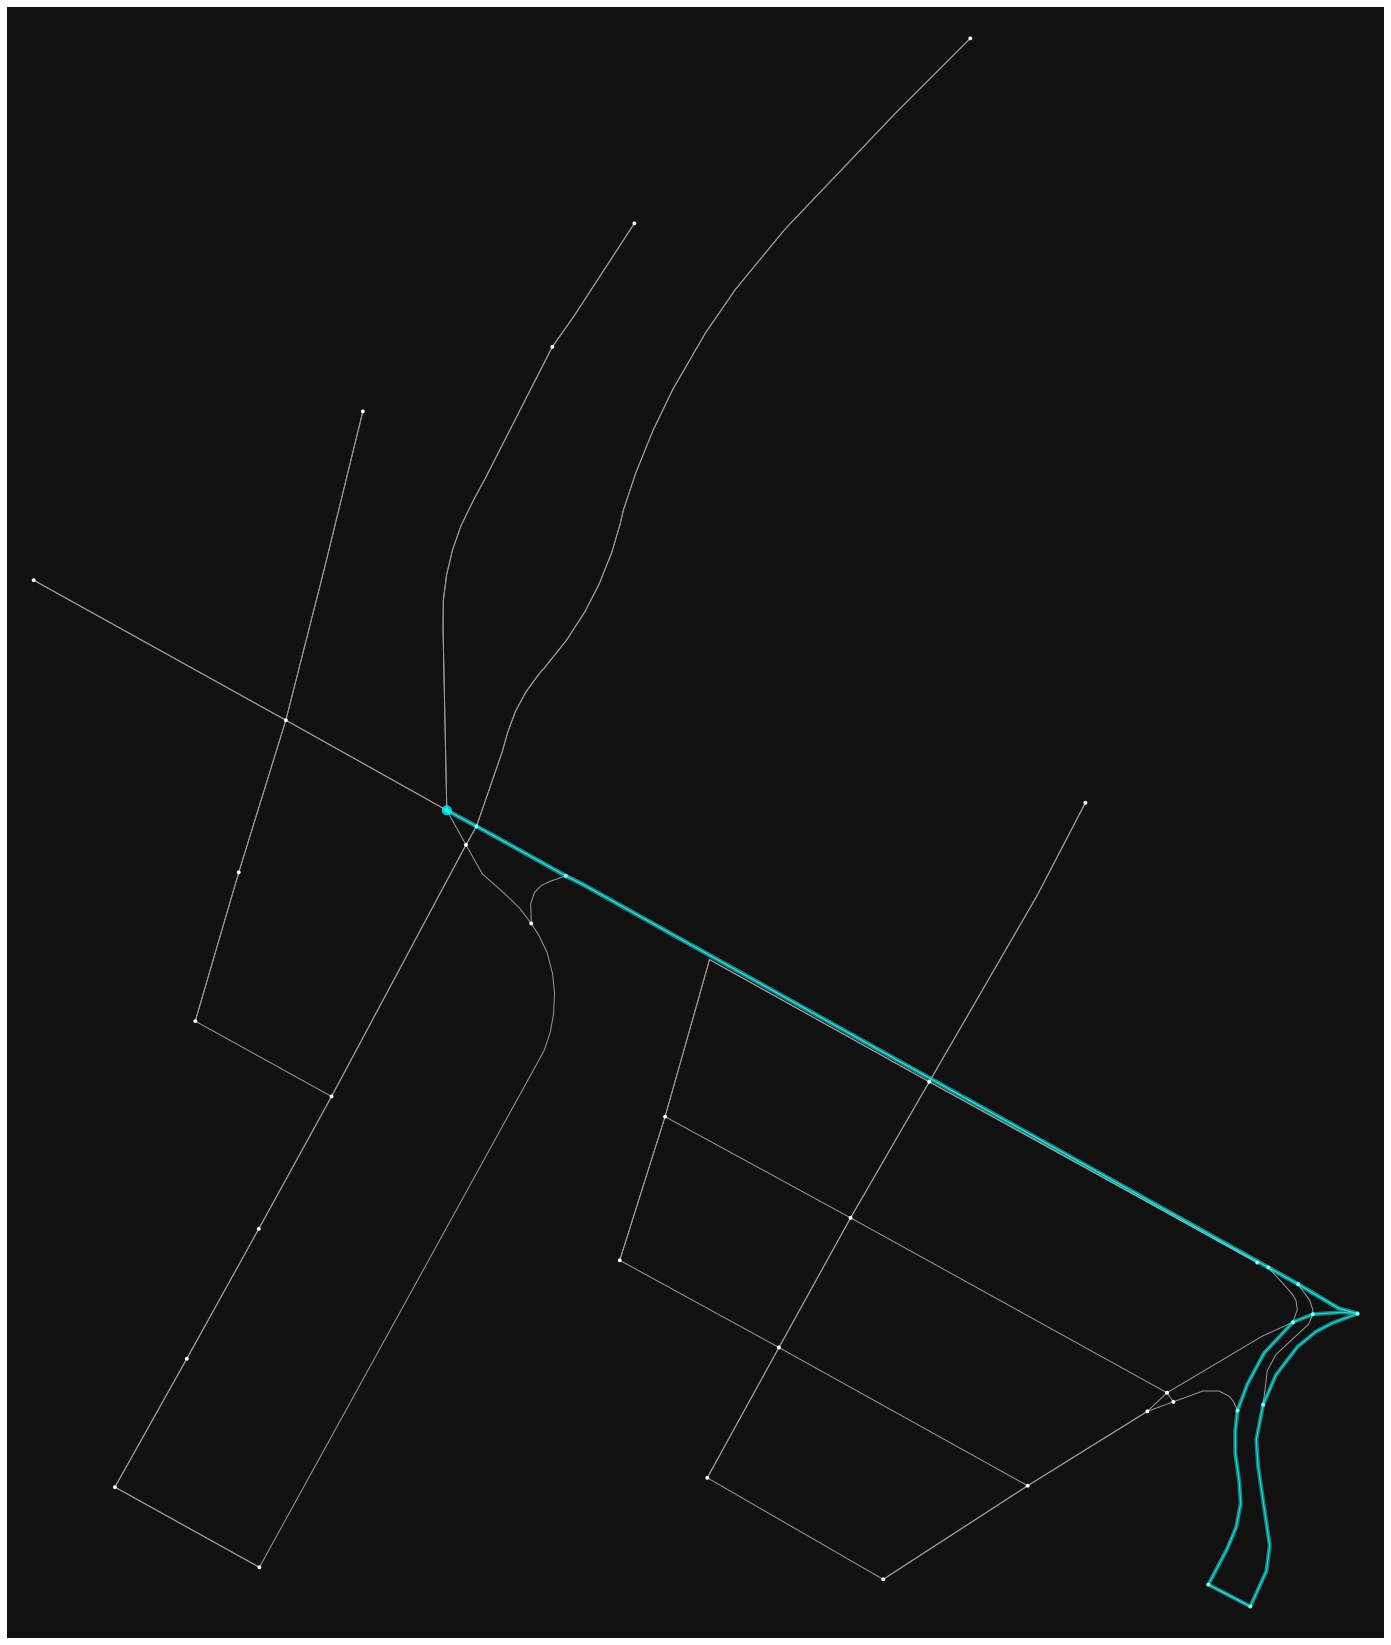

example-12/route-2.png


/home/zh223/miniconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/zh223/miniconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


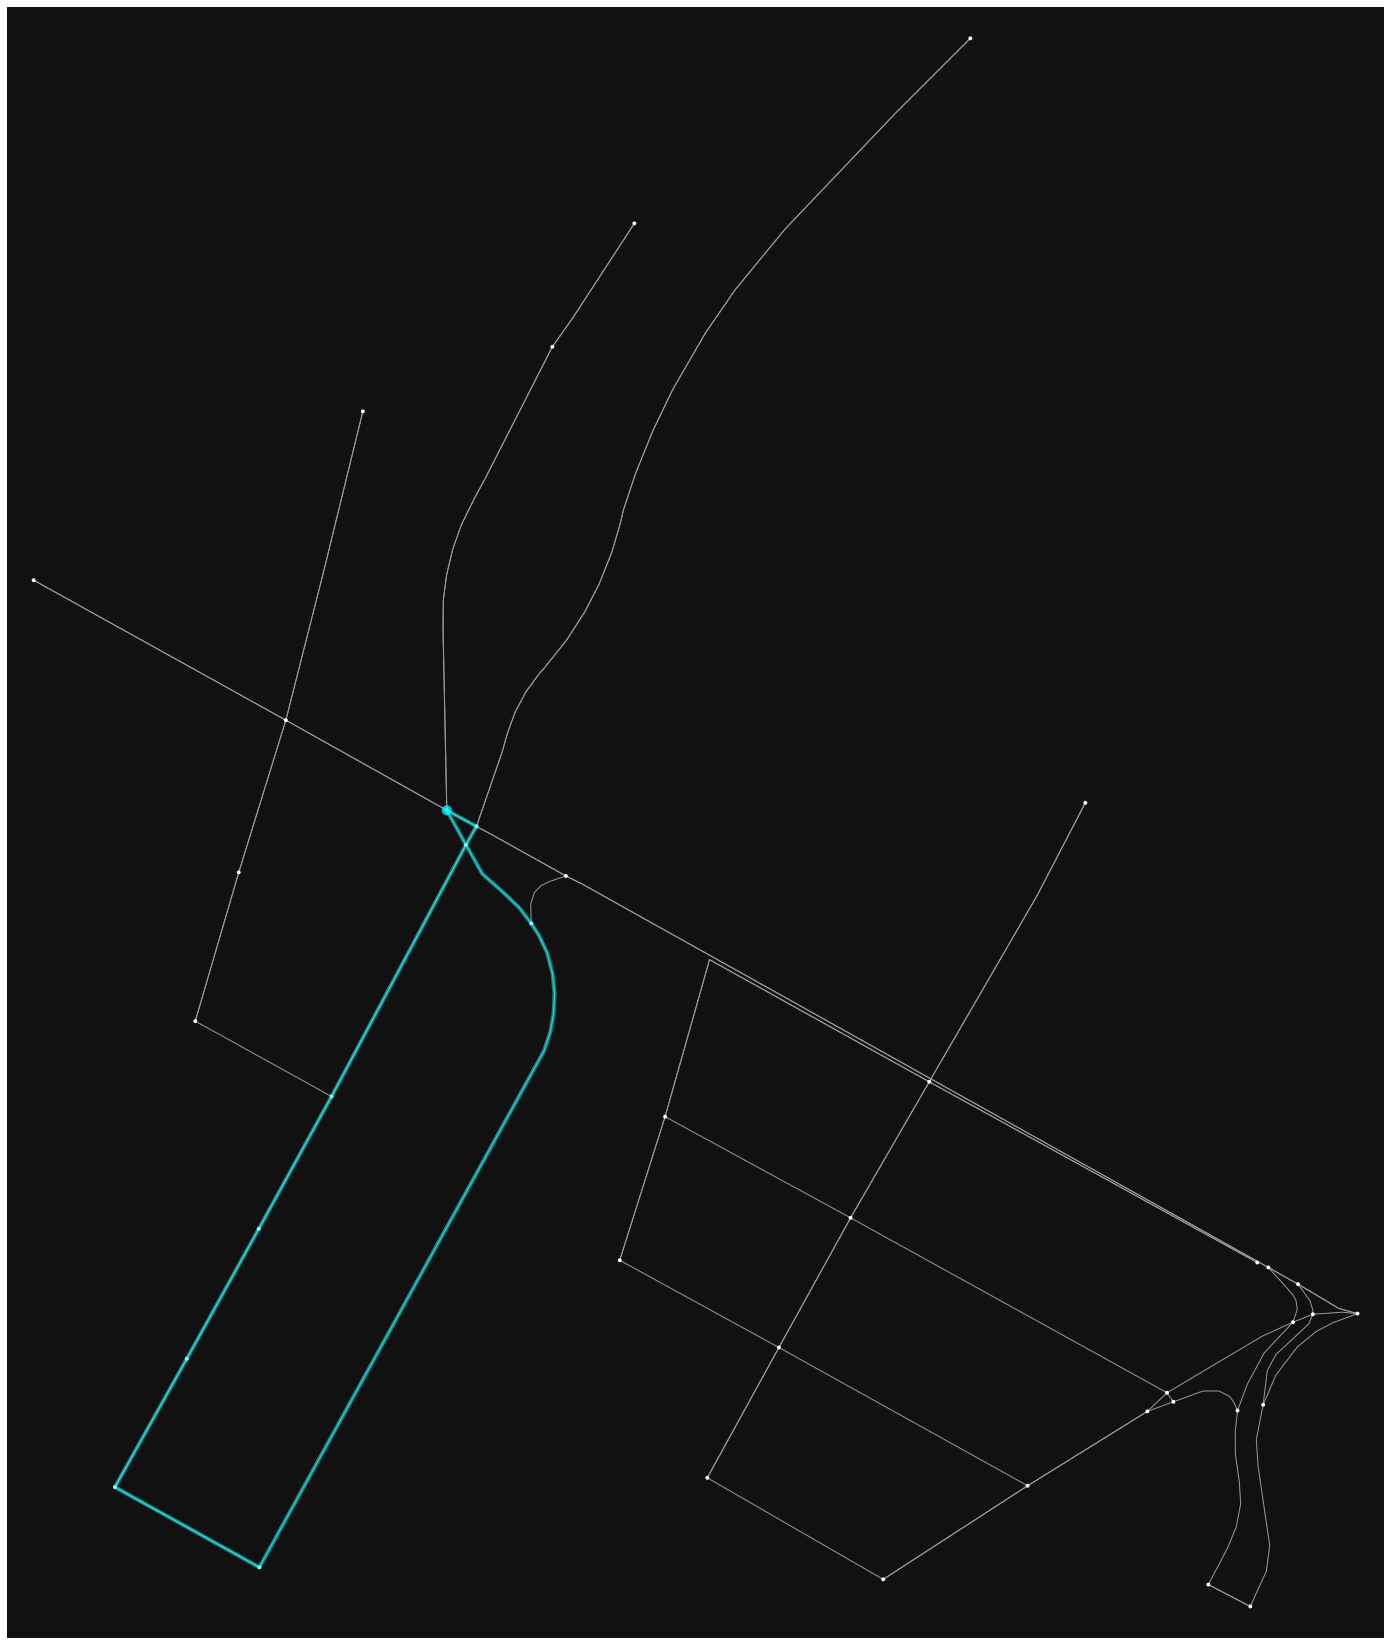

In [17]:
"""
Visualize all routes and output the figures 
"""


color_list = []
for i in range(5):
    random_number = random.randint(0,16777215)
    hex_number = str(hex(random_number))
    hex_number ='#'+ hex_number[2:]
    color_list.append(hex_number)
print(color_list)

counter = 0
for m in range(len(route)):
    if len(route[m]) <= 1:
        counter += 1
    if len(route[m]) > 1:
        print('example-' + str(example) + '/route-' + str(m - counter + 1)+'.png')
        ox.plot.plot_graph_route(G, route[m], route_color = '#00FFFF', route_linewidth=4,
                        route_alpha=0.5, orig_dest_size=100, figsize = (30, 30), save = True, filepath = 'example-' + str(example) + '/route-' + str(m - counter + 1)+'.png')

In [48]:
# Sanity check for the solution numerically 

# m = 2
# print('t_im: ' + str(t[0, m].X))
# print('t_jm: ' + str(t[1, m].X))
# print('delta_t: ' + str(t[1, m].X - t[0, m].X))
# print('travel_time: ' + str(G_e[0][1][0]['travel_time']))
# print('a_q: ' + str(a[0]))
# print('b_q: ' + str(b[0]))
# print('alpha: ' + str(alpha[0, 0, 1, 0].X))
# print('beta: ' + str(beta[0, 0, 1, 0].X))


In [49]:
# More debugging test

# print(tmp_route)
# print(route)
# print(new_to_old[53])
# print(new_to_old[15])
# print(G_e.has_edge(53, 15))
# print(G.has_edge(42432871, 42455963))
# print(list(G.successors(K[0])))
# print(list(G_e.successors(53)))
# print(old_to_new[42454660])

In [50]:
# Check that disjoint_union works

# W = nx.Graph([(0, 1), (323, 333)])
# print(W.nodes())
# R = copy.deepcopy(W)
# print(R.nodes())
# I = nx.disjoint_union(W, R)
# print(I.nodes())
# print(I.has_edge(6, 5))